In [1]:
import numpy as np
import pvml
import matplotlib.pyplot as plt


# LOAD THE LIST OF CLASSES
words = open("../data/speech-comands/classes.txt").read().split()

# LOAD THE TRAINING AND TEST DATA
data = np.load("../data/speech-comands/train.npz")
Xtrain = data["arr_0"]
Ytrain = data["arr_1"]
print(Xtrain.shape, Ytrain.shape)
data = np.load("../data/speech-comands/test.npz")
Xtest = data["arr_0"]
Ytest = data["arr_1"]
print(Xtest.shape, Ytest.shape)
spectrogram = Xtrain[0, :].reshape(20, 80)

(84291, 1600) (84291,)
(9376, 1600) (9376,)


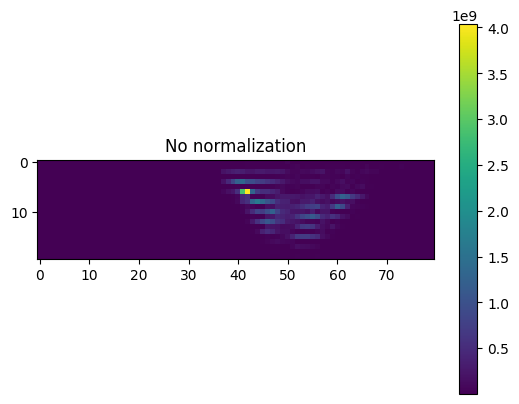

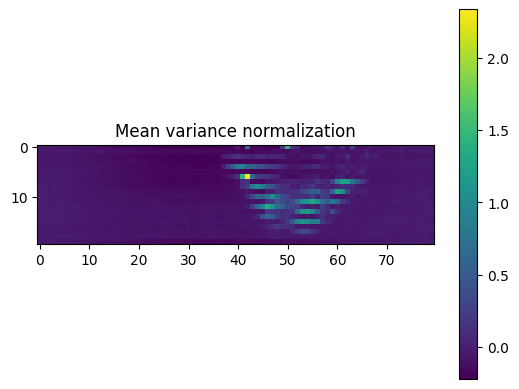

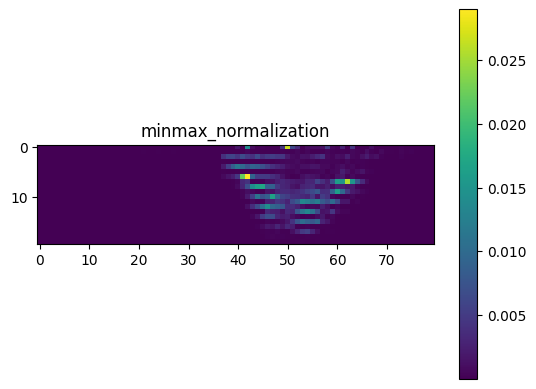

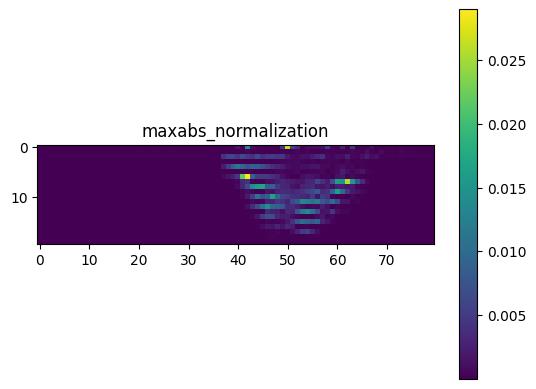

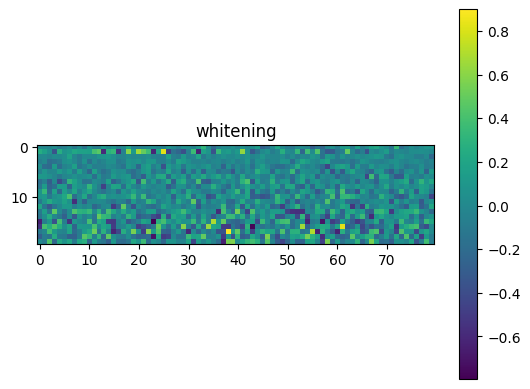

In [6]:
import trainmodel as tm
spectrogram_no_norm = Xtrain[0, :].reshape(20, 80)
plt.imshow(spectrogram_no_norm)
plt.colorbar()
plt.title("No normalization")
plt.show()

xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
spectrogram_mean_var = xTrainMV[0, :].reshape(20, 80)

plt.imshow(spectrogram_mean_var)
plt.colorbar()
plt.title("Mean variance normalization")
plt.show()

xTrain, xTest = tm.minmax_normalization(Xtrain, Xtest)
spectrogram_min_max = xTrain[0, :].reshape(20, 80)

plt.imshow(spectrogram_min_max)
plt.colorbar()
plt.title("minmax_normalization")
plt.show()

xTrainMA, xTestMA = tm.maxabs_normalization(Xtrain, Xtest)
spectrogram_max_abs = xTrainMA[0, :].reshape(20, 80)

plt.imshow(spectrogram_max_abs)
plt.colorbar()
plt.title("maxabs_normalization")
plt.show()

xTrain, xTest = tm.whitening(Xtrain, Xtest)
spectrogram_whitning = xTrain[0, :].reshape(20, 80)

plt.imshow(spectrogram_whitning)
plt.colorbar()
plt.title("whitening")
plt.show()

In [4]:
import trainmodel as tm
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
m = xTrainMV.shape[0]
net = pvml.MLP([1600,128, 35])
plt.ion()
train_accs = []
test_accs = []
epochs = []
batch_size = 20
for epoch in range(30):
    net.train(xTrainMV, Ytrain, 1e-4, steps=m // batch_size,
              batch=batch_size)
    if epoch % 5 == 0:
        train_acc = tm.accuracy(net, xTrainMV, Ytrain)
        test_acc = tm.accuracy(net, xTestMV, Ytest)
        print(epoch, train_acc, test_acc)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        epochs.append(epoch)
net.save("model.npz")

0 19.05541516887924 16.030290102389078


KeyboardInterrupt: 

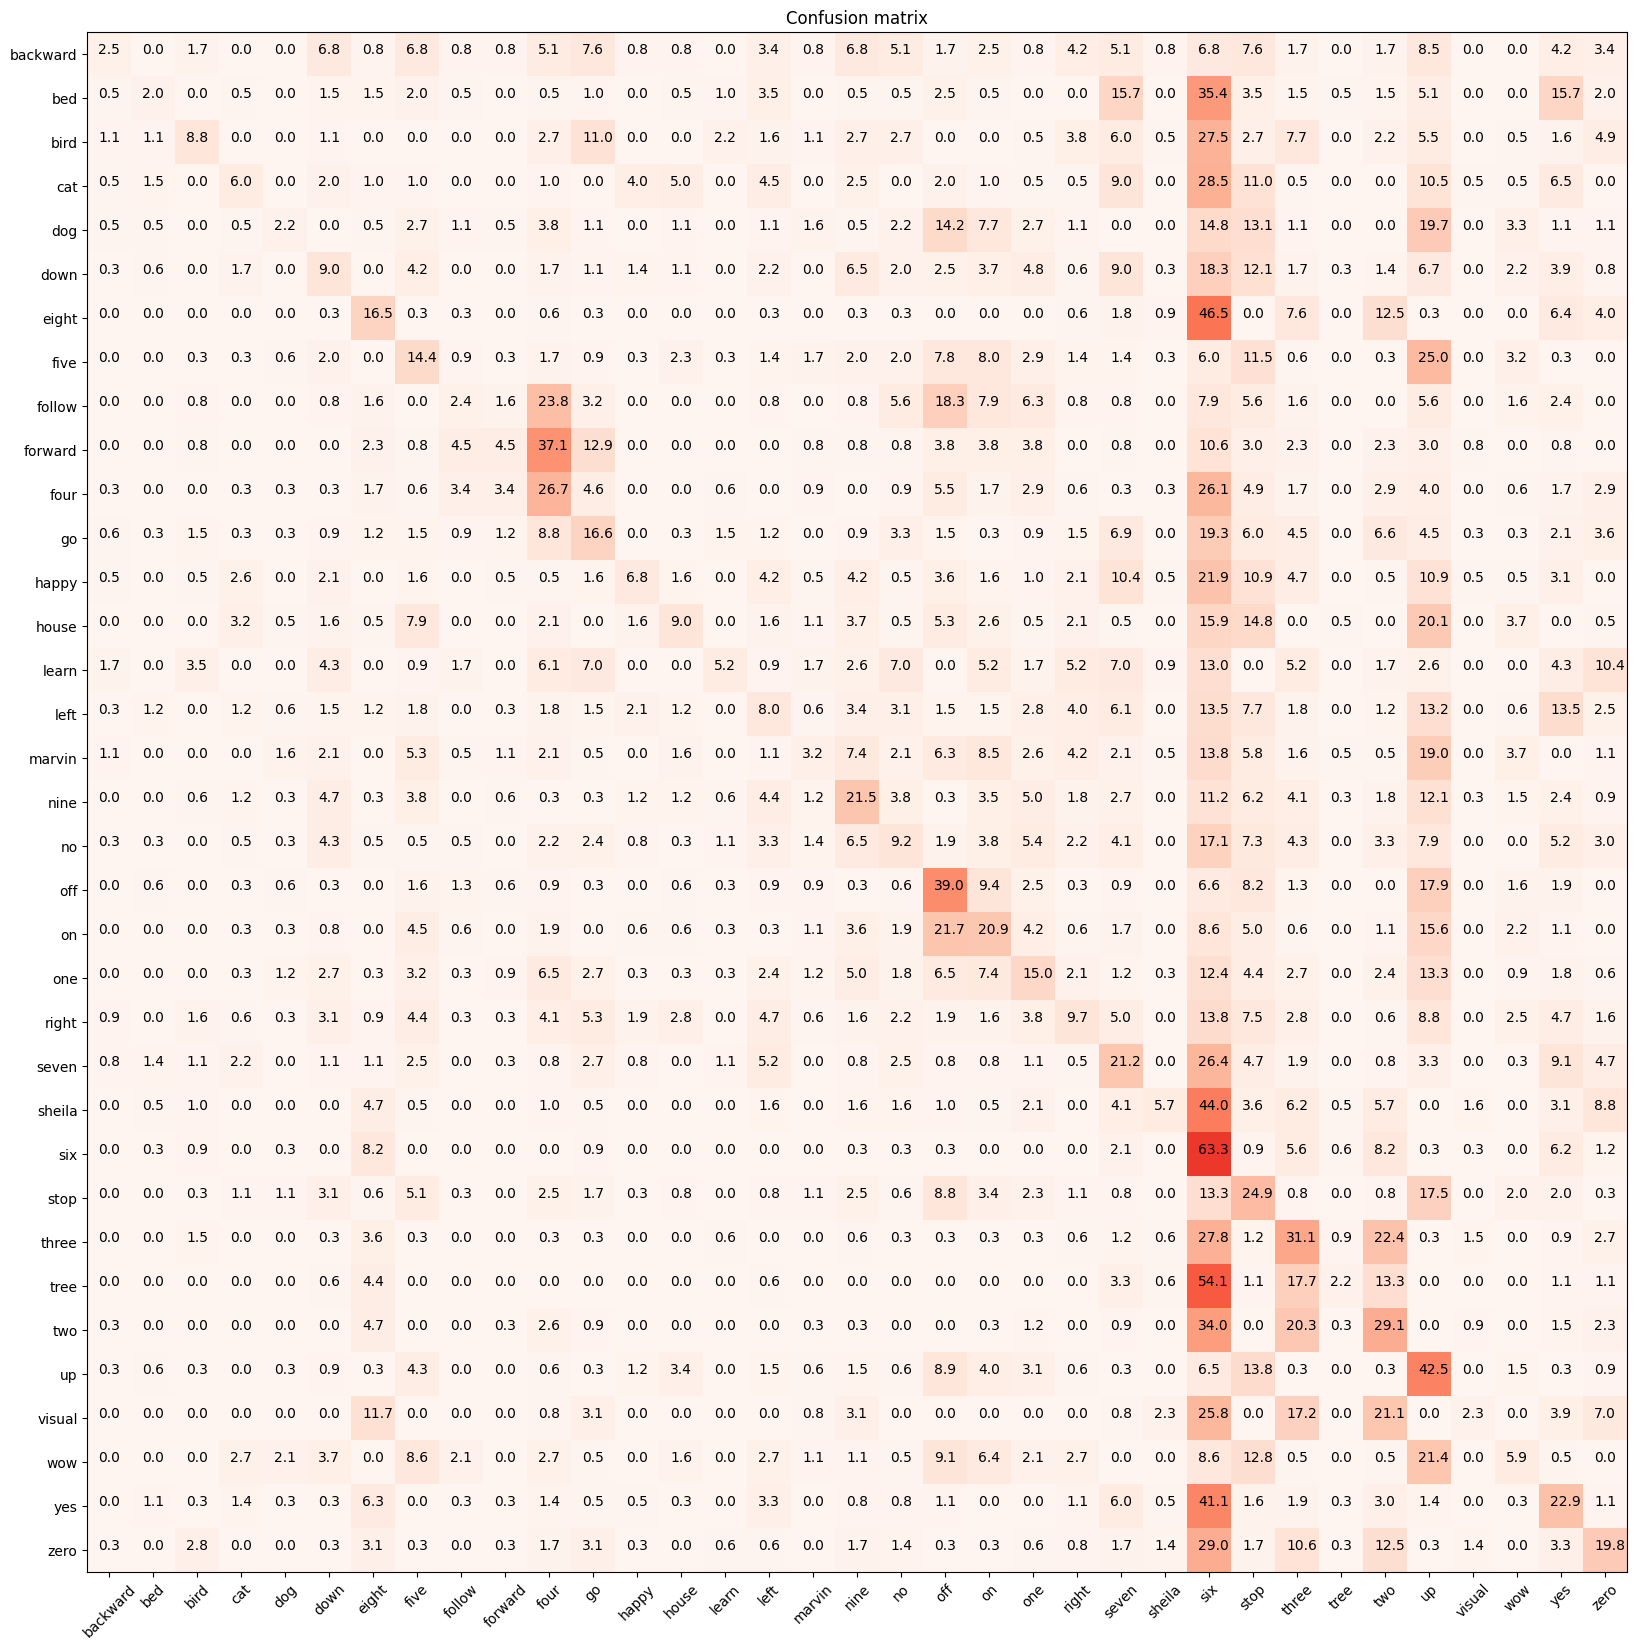

In [3]:
import analysis as an
import trainmodel as tm
import pvml
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
network = pvml.MLP.load("model.npz")
predictions, logits = network.inference(xTestMV)
cmat = an.make_confusion_matrix(predictions, Ytest)
an.show_confusion_matrix(Ytest, predictions, words)